In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
from scipy import linalg
from scipy.spatial.distance import cdist
from sklearn.utils.graph_shortest_path import graph_shortest_path

from tqdm import trange, tqdm
neighbours=50
eps=False

In [2]:
columns = ['animal_name','hair','feathers','eggs','milk','airborne','aquatic',
          'predator','toothed','backbone','breathes','venomous','fins','legs','tail',
          'domestic','catsize','type']

zoo_data = pd.read_csv("zoo.data", sep=",",names=columns)

In [3]:
data=zoo_data.to_numpy()
labels=data[:,-1]
data_raw=data[:,1:-2]

In [4]:
dim1,dim2=data_raw.shape

In [5]:
def findDistances(data_raw):
    """
    Construct the distance matrix using the Euclidean distance.
    Input: data_raw[nr_elements,nr_attributes] is the raw data stacked in a column.
    Output: distances[nr_elements,nr_elements] is the distance matrix contain all the pair distances of elements.
    """
    dim1,dim2=data_raw.shape
    distances=np.zeros((dim1,dim1))
    for i in tqdm(range(dim1-1)):
        for j in range(i+1,dim1):
            distances[i,j]=np.sqrt(np.sum((data_raw[i,:]-data_raw[j,:])**2))
    distances+=distances.T
    return distances

In [6]:
def constructGraph(data_raw,eps=30,neighbours=False):
    """
    Construct a connected graph based on the similarity matrix.
    Input: distances[nr_elements,nr_elements] is the distance matrix contain all the pair distances of elements.
    Output: graph_matrix[nr_elements,nr_elements] is the matrix containing the pairwise distances of the connected nodes.
    """
    dim=distances.shape[0]
    graph_matrix=np.copy(distances)
    if neighbours:
        for i in tqdm(range(dim)):
            # Ascending sorted indexes
            sorted_indexes=np.argsort(distances[i,:])
            # k-th smallest dimension
            max_distance=distances[i,sorted_indexes[neighbours-1]]

            for j in range(dim):
                if distances[i,j]>max_distance:
                    graph_matrix[i,j]=np.inf
                    graph_matrix[j,i]=np.inf
        return graph_matrix
    elif eps:
        truncated_connections=np.zeros_like(graph_matrix)+np.inf
        indexes_no_connection = graph_matrix < eps
        truncated_connections[indexes_no_connection] = graph_matrix[indexes_no_connection]
        return truncated_connections

In [7]:
def spectralClustering(distance_matric):
    """
    Perform Spectral Clustering on the computed graph.
    """
    distance_matrix=np.copy(distance_matric)
    distance_matrix[distance_matrix == np.inf] = 0
    degree=distance_matrix.sum(axis=0)
    laplacian_matrix=np.diag(degree)-distance_matrix
    lambd,u=np.linalg.eigh(laplacian_matrix)
    return lambd

In [8]:
def floydMarshall(graph_matrix):
    """
    Get the shortest path from one element to all the others.
    Input: graph_matrix[nr_elements,nr_elements] is the matrix containing the pairwise distances of the connected nodes.
           Check constructGraph(data_raw,eps=30,neighbours=3)
    Output:shortest_paths[nr_elements,nr_elements] 
    """
    dim=graph_matrix.shape[0]
    shortest_paths=np.copy(graph_matrix)
    for k in tqdm(range(dim)):
        for i in range(dim):
            for j in range(dim):
                if shortest_paths[i,j]>shortest_paths[i,k]+shortest_paths[k,j]:
                    shortest_paths[i,j]=shortest_paths[i,k]+shortest_paths[k,j]
    return shortest_paths                

In [9]:
def doubleCentric(shortest_paths):
    """
    Double centric operation
    Input:shortest_paths[nr_items,nr_items] matrix containing the shortest paths in distance.
    Output:  gram_matrix[nr_items,nr_items] matrix containing the shortest paths in similarity.
    """
    
    distance_matric=np.copy(shortest_paths)
    distance_matric[distance_matric == np.inf] = 0
    
    mean_row=distance_matric.mean(axis=0)
    mean_row=np.expand_dims(mean_row,axis=1)
    mean_row=np.repeat(mean_row,mean_row.shape[0],axis=1)
    
    mean_column=distance_matric.mean(axis=1)
    mean_column=np.expand_dims(mean_column,axis=0)
    mean_column=np.repeat(mean_column,mean_column.shape[1],axis=0)
    
    mean_total=distance_matric.ravel().mean()
    gram_matrix=-0.5*(distance_matric-mean_row-mean_column+mean_total)

    return gram_matrix


100%|██████████| 101/101 [00:00<00:00, 142.59it/s]


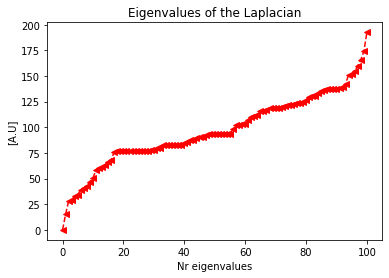

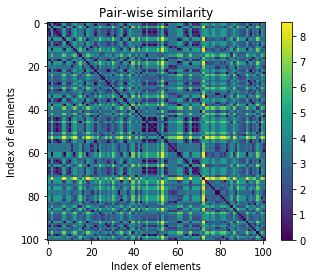

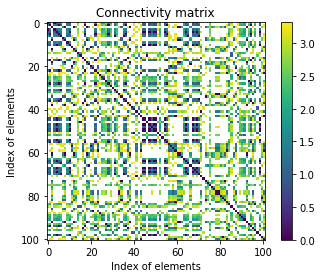

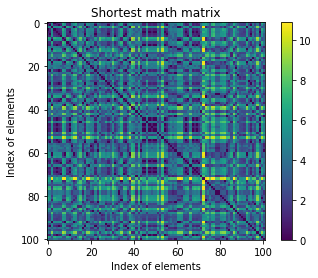

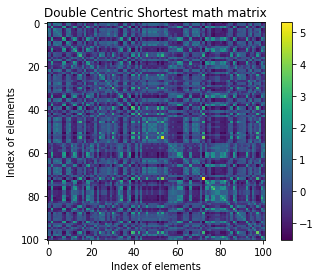

In [10]:
## Just for debugging porpuse.

distances=findDistances(data_raw)
graph_matrix=constructGraph(distances,eps=eps,neighbours=neighbours)
lambd=spectralClustering(graph_matrix)
shortest_paths=floydMarshall(graph_matrix)
double_centric=doubleCentric(shortest_paths)

plt.figure(5)
plt.plot(lambd,'r--')
plt.plot(lambd,'r<')
plt.xlabel('Nr eigenvalues')
plt.ylabel('[A.U]')
plt.title('Eigenvalues of the Laplacian')
plt.savefig('ISOMAPfig7.png')
plt.show()

plt.figure(1)
plt.imshow(distances)
plt.title('Pair-wise similarity')
plt.xlabel('Index of elements')
plt.ylabel('Index of elements')
plt.colorbar()
plt.savefig('ISOMAPfig1.png')
plt.show()
plt.figure(2)
plt.imshow(graph_matrix)
plt.title('Connectivity matrix')
plt.xlabel('Index of elements')
plt.ylabel('Index of elements')
plt.colorbar()
plt.savefig('ISOMAPfig2.png')
plt.show()

plt.figure(3)
plt.imshow(shortest_paths)
plt.title('Shortest math matrix')
plt.xlabel('Index of elements')
plt.ylabel('Index of elements')
plt.colorbar()
plt.savefig('ISOMAPfig3.png')
plt.show()

plt.figure(3)
plt.imshow(double_centric)
plt.title('Double Centric Shortest math matrix')
plt.xlabel('Index of elements')
plt.ylabel('Index of elements')
plt.colorbar()
plt.savefig('ISOMAPfig8.png')
plt.show()



In [11]:

def isomap(data_raw,eps=3,neighbours=3,double_centric=False,API=False):
    """
    Perform Isomap on the dataset:
    Input: data_raw[nr_elements,nr_attributes] is the raw data stacked in a column.
    Output:eigenvalues[nr_elements] is the array containing the eigenvalues
           eigenvectors[nr_elements,nr_elements] is the matrix containing the eigenvectors per column.
    """
    if neighbours<1:
        neighbours==1
    
    # Construct the distance matrix
    print('\n Finding the distances.')
    distances=findDistances(data_raw)
    print('\n Finished finding the distances.')
    # Construct the graph
    print('\n Finding the connectivity graph.')
    graph_matrix=constructGraph(distances,eps=eps,neighbours=neighbours)
    print('\n Finished finding the connectivity graph.')
    # Find the shortest path
    print('\n Finding the shortest paths.')
    #shortest_paths=floydMarshall(graph_matrix)
    print('\n Finished finding the shortest paths.')
    if API:
        graph = csr_matrix(graph_matrix)
        shortest_paths, predecessors = floyd_warshall(csgraph=graph, 
                                           directed=False, 
                                           return_predecessors=True)
    else:
        shortest_paths=floydMarshall(graph_matrix)
    if double_centric:
        shortest_paths=doubleCentric(shortest_paths)
    else:
        shortest_paths[shortest_paths == np.inf] = 0
    # Perform eigenvalue decomposition EVD
    eigenvalues,eigenvectors=np.linalg.eigh(shortest_paths)
    return eigenvalues,eigenvectors

In [12]:
w,u=isomap(data_raw,
           eps=eps,
           neighbours=neighbours,
           double_centric=True,
           API=True)

100%|██████████| 101/101 [00:00<00:00, 13661.79it/s]


 Finding the distances.

 Finished finding the distances.

 Finding the connectivity graph.

 Finished finding the connectivity graph.

 Finding the shortest paths.

 Finished finding the shortest paths.


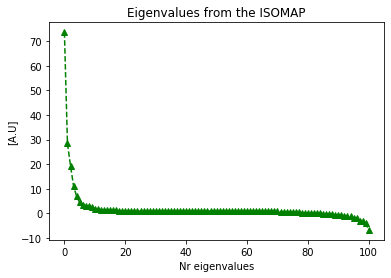

In [13]:
plt.figure()
plt.plot(np.flip(w),'g--')
plt.plot(np.flip(w),'g^')
plt.xlabel('Nr eigenvalues')
plt.ylabel('[A.U]')
plt.title('Eigenvalues from the ISOMAP')
plt.savefig('ISOMAPfig4.png')
plt.show()

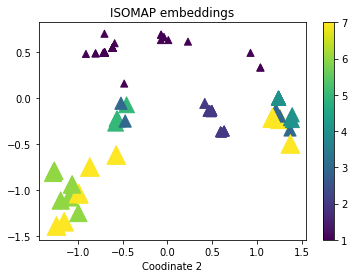

In [14]:
plt.figure()
index1=-1
index2=-2
plt.scatter(np.sqrt(np.real(w[index1]))*np.real(u[:,index1]),
            np.sqrt(np.real(w[index2]))*np.real(u[:,index2]),
            s=50*labels.astype(int),
            marker='^', 
            c=labels)
plt.xlabel('Coodinate 1')
plt.xlabel('Coodinate 2')
plt.title ('ISOMAP embeddings')
plt.colorbar()
plt.savefig('ISOMAPfig5.png')
plt.show()

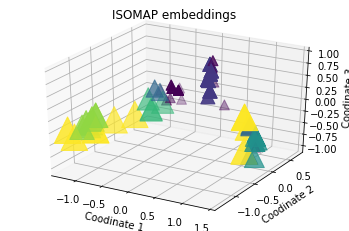

In [15]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
index3=-3
ax.scatter( np.sqrt(np.real(w[index1]))*np.real(u[:,index1]),
            np.sqrt(np.real(w[index2]))*np.real(u[:,index2]),
            np.sqrt(np.real(w[index3]))*np.real(u[:,index3]),
            s=100*labels.astype(int),
            marker='^', 
            c=labels)
ax.set_xlabel('Coodinate 1')
ax.set_ylabel('Coodinate 2')
ax.set_zlabel('Coodinate 3')
plt.title ('ISOMAP embeddings')
plt.savefig('ISOMAPfig6.png')
plt.show()